In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from scipy import sparse 
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from task4.oracles import create_lasso_prox_oracle, create_lasso_nonsmooth_oracle
from task4.optimization import accelerated_proximal_gradient_descent, proximal_gradient_descent, subgradient_method
from task1.optimization import newton

In [109]:
from sklearn.datasets import load_svmlight_file
from tqdm import tqdm

In [ ]:
matplotlib.rcParams.update({'font.size': 14})

# Эксперимент 3.1. Выбор $\alpha_0$ для субградиентного метода

In [247]:
np.random.seed(42)

In [ ]:
alphas = [0.2, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 7, 10, 15]
taus = np.linspace(0.1, 0.9, 9)

In [273]:
%%time

n = 100
m = 100
b_noise_ampl = 0
A = sparse.diags([np.random.rand(n)], [0]).tocsr()
x_true = sparse.rand(1, n, density=0.01)
b = A.dot(x_true.T).T
regcoef = 1/n
synt_sub = create_lasso_nonsmooth_oracle(A, b, regcoef)
x_distant = sparse.csr_matrix(np.ones(n)*5)
x_optimal, msg , hist = subgradient_method(synt_sub, x_distant, trace=True, max_iter=10000, tolerance=1e-1, alpha_0=1)

print(msg)

success
CPU times: user 12.4 s, sys: 476 ms, total: 12.9 s
Wall time: 13.6 s


In [283]:
%%time

histories = []
for tau in tqdm(taus):
    x_0 = tau*x_distant + (1 - tau)*x_optimal
    loc_histories = []
    for alpha in alphas:
        _, _, hist = subgradient_method(synt_sub, x_0, trace=True, max_iter=10000, tolerance=1e-1, alpha_0=alpha)
        loc_histories.append(hist)
    histories.append(loc_histories)

100%|██████████| 8/8 [09:27<00:00, 70.89s/it]

CPU times: user 9min 9s, sys: 6.77 s, total: 9min 15s
Wall time: 9min 27s


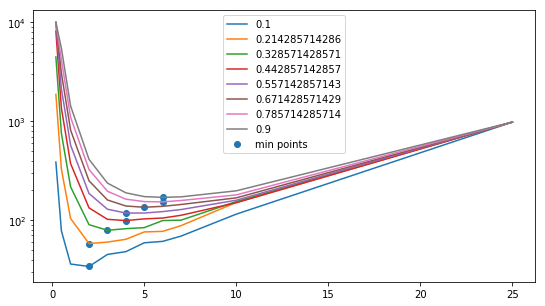

In [285]:
figure(figsize=(9, 5))
min_x = []
min_y = []
min_z = []
for tau, hists in zip(taus, histories):
    iters = [len(hist["time"]) for hist in hists]
    min_point = np.argmin(iters)
    min_x.append(alphas[min_point])
    min_y.append(len(hists[min_point]["time"]))
    min_z.append(taus[min_point])
    semilogy(alphas, iters, label=tau)
scatter(min_x, min_y, label = "min points")
legend()

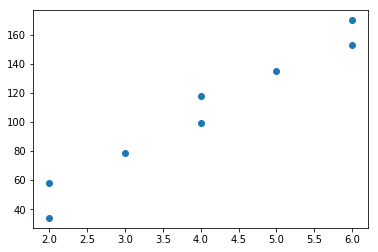

In [292]:
scatter(min_x, min_y)

# Эксперимент 3.2: среднее число внутренних итераций проксимальных методов 

In [286]:
np.random.seed(42)

In [298]:
hists_prox = []
hists_acc = []

for _ in tqdm(range(10)):
    n = int(100 + np.random.rand()*10000)
    m = n
    diag_ampl = np.random.rand()*30
    A = sparse.diags([np.random.rand(n)*diag_ampl], [0]).tocsr()
    x_true = sparse.rand(1, n, density=0.1)
    b = A.dot(x_true.T).T
    regcoef = 1/n
    synt_sub = create_lasso_prox_oracle(A, b, regcoef)
    x_0 = sparse.csr_matrix((1, n))
    
    x_optimal, msg , hist_prox = proximal_gradient_descent(synt_sub, x_0, trace=True,
                                                           max_iter=10000, tolerance=1e-1)
    x_optimal, msg , hist_acc = proximal_gradient_descent(synt_sub, x_0, trace=True, 
                                                          max_iter=10000, tolerance=1e-1)
    
    hists_prox.append(hist_prox)
    hists_acc.append(hist_acc)

100%|██████████| 10/10 [03:39<00:00, 21.99s/it]


[2.0026737967914436, 2.0165289256198347, 2.0045592705167175, 2.0052966101694913, 2.0126582278481013, 2.008298755186722, 2.021276595744681, 1.9411764705882353, 2.008695652173913, 2.0038784744667097]
[2.0026737967914436, 2.0165289256198347, 2.0045592705167175, 2.0052966101694913, 2.0126582278481013, 2.008298755186722, 2.021276595744681, 1.9411764705882353, 2.008695652173913, 2.0038784744667097]


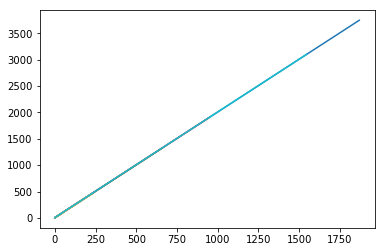

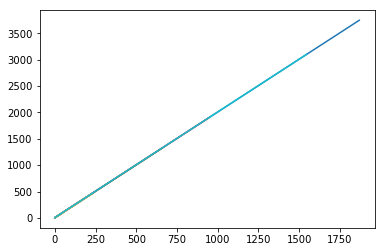

In [299]:
figure()
prox_mean = []
for h_p in hists_prox:
    plot(h_p["inner_iters"])
    prox_mean.append(h_p["inner_iters"][-1]/len(h_p["inner_iters"]))
figure()
acc_mean = []
for h_a in hists_acc:
    plot(h_a["inner_iters"])
    acc_mean.append(h_a["inner_iters"][-1]/len(h_a["inner_iters"]))

In [300]:
import seaborn as sns

/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


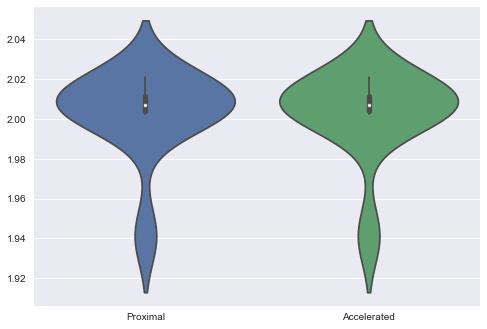

In [301]:
sns.violinplot(x = ["Proximal"]*len(prox_mean) + ["Accelerated"]*len(acc_mean), y = prox_mean + acc_mean)

# Сравнение методов

## Реальные данные (real-sim)

In [19]:
A_rs, b_rs = load_svmlight_file("datasets/real-sim")
b_rs = sparse.csr_matrix(b_rs)
rs_prox = create_lasso_prox_oracle(A_rs, b_rs, regcoef=1 / A_rs.shape[1])
rs_sub = create_lasso_nonsmooth_oracle(A_rs, b_rs, regcoef=1/A_rs.shape[1])
x_0 = sparse.rand(1, A_rs.shape[1], density=0.1)

In [22]:
%%time
[x_star, status, hist_sub] = subgradient_method(rs_sub, x_0, trace=True, max_iter=1000, tolerance=2e3)
print(status)

iterations_exceeded
CPU times: user 2min 56s, sys: 4.35 s, total: 3min
Wall time: 3min 15s


In [23]:
%%time
[x_star, status, hist_pr] = proximal_gradient_descent(rs_prox, x_0, trace=True, max_iter=1000, tolerance=2e3)
print(status)

iterations_exceeded
CPU times: user 4min 53s, sys: 7.35 s, total: 5min 1s
Wall time: 5min 28s


In [24]:
%%time
[x_star, status, hist_acc] = accelerated_proximal_gradient_descent(rs_prox, x_0, trace=True, 
                                                                   max_iter=1000, tolerance=2e3)
print(status)

iterations_exceeded
CPU times: user 6min 26s, sys: 8.25 s, total: 6min 34s
Wall time: 6min 58s


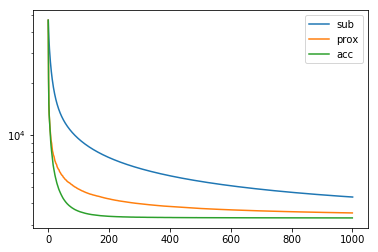

In [25]:
semilogy(hist_sub["duality_gap"], label="sub")
semilogy(hist_pr["duality_gap"], label="prox")
semilogy(hist_acc["duality_gap"], label="acc")
legend()

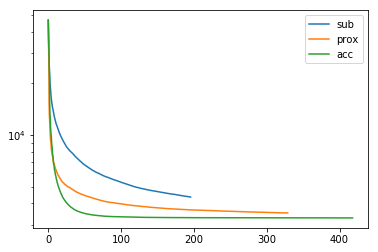

In [26]:
semilogy(hist_sub["time"], hist_sub["duality_gap"], label="sub")
semilogy(hist_pr["time"], hist_pr["duality_gap"], label="prox")
semilogy(hist_acc["time"], hist_acc["duality_gap"], label="acc")
legend()

## Реальные данные (w8a)

In [28]:
A_rcv, b_rcv = load_svmlight_file("datasets/rcv1_train")
b_rcv = sparse.csr_matrix(b_rcv)
rcv_prox = create_lasso_prox_oracle(A_rcv, b_rcv, regcoef=1 / A_rcv.shape[1])
rcv_sub = create_lasso_nonsmooth_oracle(A_rcv, b_rcv, regcoef=1/A_rcv.shape[1])
x_0 = sparse.rand(1, A_rcv.shape[1], density=0.1)

In [32]:
%%time
[x_star, status, hist_rcv_sub] = subgradient_method(rcv_sub, x_0, trace=True, max_iter=1000, tolerance=1e2)
print(status)

iterations_exceeded
CPU times: user 1min 36s, sys: 1.27 s, total: 1min 37s
Wall time: 1min 38s


In [33]:
%%time
[x_star, status, hist_rcv_pr] = proximal_gradient_descent(rcv_prox, x_0, trace=True, max_iter=1000, tolerance=1e2)
print(status)

iterations_exceeded
CPU times: user 3min 1s, sys: 1.76 s, total: 3min 2s
Wall time: 3min 3s


In [36]:
%%time
[x_star, status, hist_rcv_acc] = accelerated_proximal_gradient_descent(rcv_prox, x_0, trace=True, 
                                                                   max_iter=1000, tolerance=1)
print(status)

iterations_exceeded
CPU times: user 5min 14s, sys: 8.12 s, total: 5min 22s
Wall time: 5min 47s


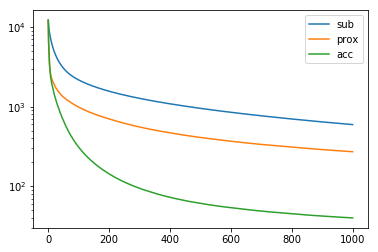

In [37]:
semilogy(hist_rcv_sub["duality_gap"], label="sub")
semilogy(hist_rcv_pr["duality_gap"], label="prox")
semilogy(hist_rcv_acc["duality_gap"], label="acc")
legend()

## Синтетические данные

## Зависимость от числа признаков n

In [319]:
ns = [1000, 5000, 10000]
eps = {1000: 1e-3, 5000: 1, 10000: 1}
ns

[1000, 5000, 10000]

In [306]:
hists_n = []
for n in tqdm(ns):
    m = 5000
    A = sparse.rand(m, n, density=0.1).tocsr()
    x_true = sparse.rand(1, n, density=0.1)
    b = A.dot(x_true.T).T
    regcoef = 1/n
    synt_prox = create_lasso_prox_oracle(A, b, regcoef)
    synt_sub = create_lasso_nonsmooth_oracle(A, b, regcoef)
    x_0 = sparse.csc_matrix((1, n))
    
    [x_star, status, hist_synt_sub] = subgradient_method(synt_sub, x_0, trace=True, 
                                                     max_iter=1000, tolerance=eps[n])
    [x_star, status, hist_synt_pr] = proximal_gradient_descent(synt_prox, x_0, trace=True, 
                                                               max_iter=1000, tolerance=eps[n])
    [x_star, status, hist_synt_acc] = accelerated_proximal_gradient_descent(synt_prox, x_0, trace=True, 
                                                                   max_iter=1000, tolerance=eps[n])
    
    hists_n.append((hist_synt_sub, hist_synt_pr, hist_synt_acc))


  0%|          | 0/4 [00:00<?, ?it/s]
Exception in thread Thread-34:
Traceback (most recent call last):
  File "/Users/aksholokhov/.anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/aksholokhov/.anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 75%|███████▌  | 3/4 [14:41<04:53, 293.74s/it]


KeyboardInterrupt: 

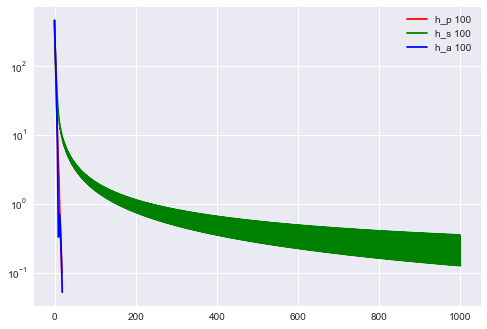

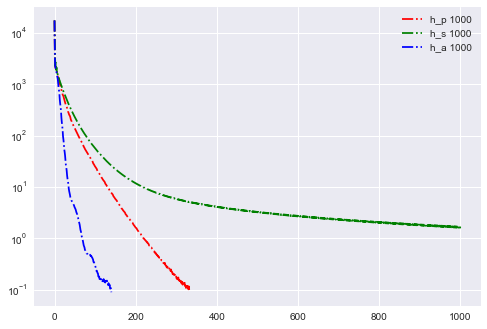

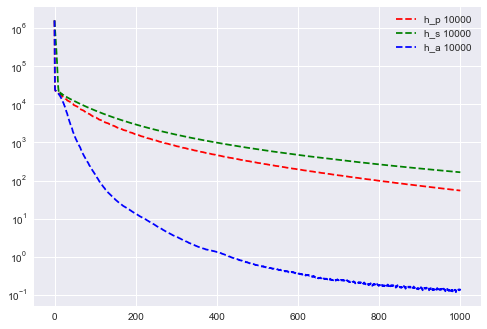

In [318]:
linestyles = ["-", "-.", "--"]
for (h_s, h_p, h_a), n, ls in zip(hists_n, ns, linestyles):
    figure()
    semilogy(h_p["duality_gap"], label = "h_p %d"%n, linestyle = ls, c = "r")
    semilogy(h_s["duality_gap"], label = "h_s %d"%n, linestyle = ls, c = "g")
    semilogy(h_a["duality_gap"], label = "h_a %d"%n, linestyle = ls, c = "b")
    legend()

In [320]:
ms = [1000, 5000, 10000]

In [321]:
hists_m = []
for m in tqdm(ms):
    n = 5000
    A = sparse.rand(m, n, density=0.1).tocsr()
    x_true = sparse.rand(1, n, density=0.1)
    b = A.dot(x_true.T).T
    regcoef = 1/n
    synt_prox = create_lasso_prox_oracle(A, b, regcoef)
    synt_sub = create_lasso_nonsmooth_oracle(A, b, regcoef)
    x_0 = sparse.csc_matrix((1, n))
    
    [x_star, status, hist_synt_sub] = subgradient_method(synt_sub, x_0, trace=True, 
                                                     max_iter=1000, tolerance=1)
    [x_star, status, hist_synt_pr] = proximal_gradient_descent(synt_prox, x_0, trace=True, 
                                                               max_iter=1000, tolerance=1)
    [x_star, status, hist_synt_acc] = accelerated_proximal_gradient_descent(synt_prox, x_0, trace=True, 
                                                                   max_iter=1000, tolerance=1)
    
    hists_m.append((hist_synt_sub, hist_synt_pr, hist_synt_acc))

100%|██████████| 3/3 [16:00<00:00, 320.26s/it]


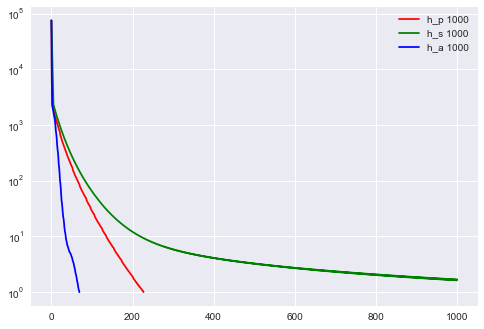

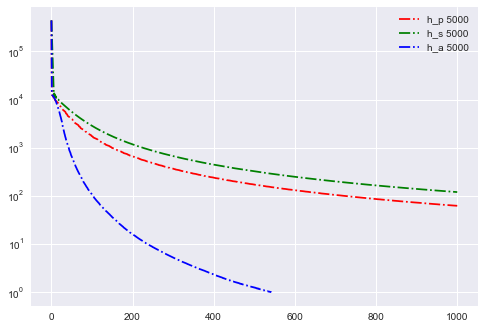

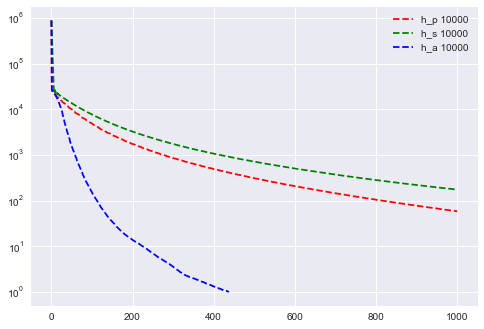

In [322]:
linestyles = ["-", "-.", "--"]
for (h_s, h_p, h_a), n, ls in zip(hists_m, ns, linestyles):
    figure()
    semilogy(h_p["duality_gap"], label = "h_p %d"%n, linestyle = ls, c = "r")
    semilogy(h_s["duality_gap"], label = "h_s %d"%n, linestyle = ls, c = "g")
    semilogy(h_a["duality_gap"], label = "h_a %d"%n, linestyle = ls, c = "b")
    legend()

In [324]:
n = 10000

lambdas = np.linspace(1/n, 1/np.sqrt(n), 5)

m = n
diag_ampl = np.random.rand()*30
A = sparse.diags([np.random.rand(n)], [0]).tocsr()
x_true = sparse.rand(1, n, density=0.1)
b = A.dot(x_true.T).T
x_0 = sparse.csc_matrix((1, n))

hists_l = []
for regcoef in tqdm(lambdas):
    
    synt_prox = create_lasso_prox_oracle(A, b, regcoef)
    synt_sub = create_lasso_nonsmooth_oracle(A, b, regcoef)

    [x_star, status, hist_synt_sub] = subgradient_method(synt_sub, x_0, trace=True, 
                                                     max_iter=1000, tolerance=1e-1)
    [x_star, status, hist_synt_pr] = proximal_gradient_descent(synt_prox, x_0, trace=True, 
                                                               max_iter=1000, tolerance=1e-1)
    [x_star, status, hist_synt_acc] = accelerated_proximal_gradient_descent(synt_prox, x_0, trace=True, 
                                                                   max_iter=1000, tolerance=1e-1)
    
    hists_l.append((hist_synt_sub, hist_synt_pr, hist_synt_acc))

100%|██████████| 5/5 [00:41<00:00,  8.23s/it]


In [328]:
for (h_s, h_p, h_a), n in zip(hists_l, lambdas):
    figure()
    semilogy(h_p["duality_gap"], label = "h_p %d"%n, c = "r")
    semilogy(h_s["duality_gap"], label = "h_s %d"%n, c = "g")
    semilogy(h_a["duality_gap"], label = "h_a %d"%n,c = "b")
    legend()

ValueError: not enough values to unpack (expected 3, got 2)

In [102]:
%%time
[x_star, status, hist_synt_sub] = subgradient_method(synt_sub, x_0, trace=True, 
                                                     max_iter=int(1e4), tolerance=1e-1, alpha_0=2)
print(status)

iterations_exceeded
CPU times: user 1min 19s, sys: 1.79 s, total: 1min 20s
Wall time: 1min 25s


In [104]:
%%time
[x_star, status, hist_synt_pr] = proximal_gradient_descent(synt_prox, x_0, trace=True, max_iter=10000, tolerance=1e-2)
print(status)

iterations_exceeded
CPU times: user 3min 49s, sys: 3.97 s, total: 3min 53s
Wall time: 4min 2s


In [105]:
%%time
[x_star, status, hist_synt_acc] = accelerated_proximal_gradient_descent(synt_prox, x_0, trace=True, 
                                                                   max_iter=10000, tolerance=1e-2)
print(status)

success
CPU times: user 25.7 s, sys: 389 ms, total: 26.1 s
Wall time: 26.7 s


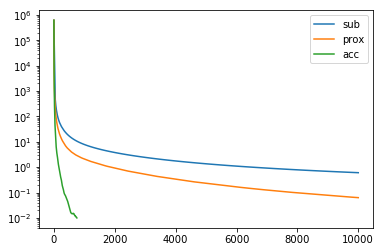

In [106]:
semilogy(hist_synt_sub["duality_gap"], label="sub")
semilogy(hist_synt_pr["duality_gap"], label="prox")
semilogy(hist_synt_acc["duality_gap"], label="acc")
legend()

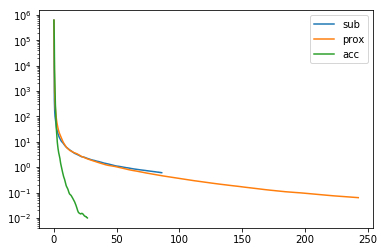

In [107]:
semilogy(hist_synt_sub["time"], hist_synt_sub["duality_gap"], label="sub")
semilogy(hist_synt_pr["time"], hist_synt_pr["duality_gap"], label="prox")
semilogy(hist_synt_acc["time"], hist_synt_acc["duality_gap"], label="acc")
legend()